So we're going to find out the best place to have a Pakistani Resaurant (since I am Pakistani and that makes sense). Points to find out:

1. It must be close, but not too close to a major food street, as that is likely where people might converge.
2. It must be close enough to the Pakistani diaspora.
3. It must be close to the median income neighbourhoods. 

In [225]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
import re
from matplotlib import pyplot as plt
import json
from folium import plugins
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# We import demographic data and clean and filter it

In [226]:
df = pd.read_csv('neighbourhood-profiles-2016-csv.csv')

## Now we import in the neighbourhood data FOR THE 140 ADMINISTRATIVE NEIGHBOURHOODS:

In [227]:
tor_ngh_data = pd.read_csv('tor_neighbourhood_locations.csv')
tor_ngh_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [228]:
tor_ngh_data.head()

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Scarborough,Agincourt North,43.808038,-79.266439,Agincourt and Brimwood
1,Scarborough,Agincourt South-Malvern West,43.781969,-79.257689,Agincourt and Malvern
2,Etobicoke,Alderwood,43.601717,-79.545232,Alderwood
3,Old City of Toronto,Annex,43.670338,-79.407117,The Annex and Seaton Village
4,North York,Banbury-Don Mills,43.670338,-79.407117,Don Mills


# BELOW IS THE FOURSQUARE DATA - DON'T RUN CONTINUOUSLY

Now we move onto the foursquare data:

def get_all_venues(latitude, longitude, neighbourhood, borough):
    
    final_dff = []
    
    CLIENT_ID ='WU2R1DNGLYATXFKLN5ITK0HXJEZR3YGYLXLUJTAY3VHPL53Z' 
    CLIENT_SECRET = 'GGGU5VRJL14XJBW3X3AN0VX50UO3GSSD1OS3X5BECJ0X5KC4' 
    ACCESS_TOKEN = 'ZDDLZJZUUWYMMU0151BLSD5BKBY5Z01D2P0LBO0UGV0VZ55Q' 
    VERSION = '20210813' 
    LIMIT = 150 
    radius = 500

    for lat, lng, ngh, bor in zip(latitude, longitude, neighbourhood, borough):
        neighborhood_latitude = lat
        neighborhood_longitude = lng
        neighborhood_name = ngh 
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        try:
            for ra in range(len(results)):
                row = {
                   'Neighbourhood':ngh, 'Borough': bor, 'Neighbourhood_Latitude':lat,'Neighbourhood_Longitude':lng,
                   'Venue':results[ra]['venue']['name'],'Venue_Latitude':results[ra]['venue']['location']['lat'],
                   'Venue_Longitude':results[ra]['venue']['location']['lng'],
                   'Venue_Category':results[ra]['venue']['categories'][0]['name']
               }
                final_dff.append(row)
                
        except Exception as err:
            print('Error occured:', err, ', skip row')
    
    ret_df = pd.DataFrame(final_dff)
    return ret_df

tor_venues = get_all_venues(tor_ngh_data['Latitude'], tor_ngh_data['Longitude'], tor_ngh_data['Location'], tor_ngh_data['Borough'])

# FOURSQUARE DATA ENDS HERE. 
## Now we have the venues for each neighbourhood

In [229]:
tor_venues = pd.read_csv('toronto_venues.csv')
tor_venues.drop('Unnamed: 0', axis = 1, inplace = True)

In [230]:
tor_venues.head()

,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Agincourt North,Scarborough,43.808038,-79.266439,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
1,Agincourt North,Scarborough,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
2,Agincourt North,Scarborough,43.808038,-79.266439,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
3,Agincourt North,Scarborough,43.808038,-79.266439,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
4,Agincourt North,Scarborough,43.808038,-79.266439,Booster Juice,43.809915,-79.269382,Juice Bar


We find all the resturants

In [231]:
resturants = tor_venues.loc[tor_venues['Venue_Category'].str.contains('Restaurant')]

In [232]:
resturants.tail()

,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2832,York University Heights,North York,43.758781,-79.519434,Pita Land,43.757520,-79.514628,Falafel Restaurant
2838,Yorkdale-Glen Park,North York,43.703434,-79.452918,McDonald's,43.704919,-79.452238,Fast Food Restaurant
2839,Yorkdale-Glen Park,North York,43.703434,-79.452918,Sky Ranch Restaurant,43.700730,-79.451684,Argentinian Restaurant
2841,Yorkdale-Glen Park,North York,43.703434,-79.452918,Darosa,43.706970,-79.453121,Mediterranean Restaurant
2845,Yorkdale-Glen Park,North York,43.703434,-79.452918,Il vagabondo,43.701480,-79.452443,Italian Restaurant


In [233]:
resturants.shape

(744, 8)

According to the above, there are 744 separate entries.

## Exploratory analysis

### Pinpoint all the restaurants on the map

First, we get Toronto's location:

In [234]:
toronto_address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='explore_toronto')
location = geolocator.geocode(toronto_address)
t_latitude = location.latitude
t_longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


The following is a function to generate random colours for each neighbourhood:

In [235]:
import random

def get_color_list():
    hexadecimal_alphabets = '0123456789ABCDEF'
    colour = "#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)])
    return colour

In [236]:
ngh_colours = {}
for neighbourhood in tor_ngh_data['Location']:
    colour = get_color_list()
    ngh_colours.update({neighbourhood: colour})

#### Now, we finally draw the map:

In [237]:
toronto_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

for ngh in resturants['Neighbourhood'].unique():
    row = tor_ngh_data.loc[tor_ngh_data['Location'] == ngh]
    nlat = row['Latitude']
    nlng = row['Longitude']
    nbor = row['Borough']
    label = '{}, {}'.format(ngh, nbor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [nlat, nlng],
        radius=12,
        popup=label,
        color=ngh_colours[ngh],
        parse_html=False).add_to(toronto_map) 


for lat, lng, neighbourhood, category in zip(
    resturants['Venue_Latitude'], resturants['Venue_Longitude'], 
    resturants['Neighbourhood'], resturants['Venue_Category']):
    label = '{}, {}'.format(neighbourhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=0.8,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

Here we see that the neighbourhoods with the greatest number of restaurants are near the coastline and the eastern side of Toronto.

# KMEANING ALL NEIGHBOURHOODS AAAAAAAAAAAAAAAAAAAAAAAAA

We get all latitudes and longitudes for k-mean clustering:

In [238]:
reslatlng = []
for lat, lng in zip(resturants['Venue_Latitude'], resturants['Venue_Longitude']):
    row =[lat, lng]
    reslatlng.append(row)

We try a range of k values to find the optimum one:

In [239]:
inertias = []
mapping = {}
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(reslatlng)
    inertias.append(kmeans.inertia_)
    mapping[k] = kmeans.inertia_


In [240]:
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 5.708182349269557
2 : 2.8516235514864547
3 : 1.8431911877689795
4 : 1.3107970953613848
5 : 0.9445875363583698
6 : 0.7686466763204448
7 : 0.610373712298232
8 : 0.486216371676208
9 : 0.41900318381219015


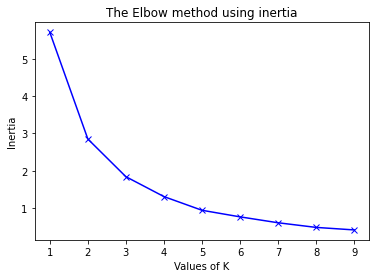

In [241]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow method using inertia')
plt.show()

Our data has no sharply defined elbow point, but the best one appears to be at k = 4. We will use this k-value to create our clusters.

In [242]:
reskmeans = KMeans(n_clusters = 4, random_state = 0).fit(reslatlng)

In [243]:
reskmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [244]:
resturants.insert(0, 'Cluster Label', reskmeans.labels_)

In [245]:
resturants.tail()

,Cluster Label,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2832,2,York University Heights,North York,43.758781,-79.519434,Pita Land,43.757520,-79.514628,Falafel Restaurant
2838,2,Yorkdale-Glen Park,North York,43.703434,-79.452918,McDonald's,43.704919,-79.452238,Fast Food Restaurant
2839,2,Yorkdale-Glen Park,North York,43.703434,-79.452918,Sky Ranch Restaurant,43.700730,-79.451684,Argentinian Restaurant
2841,2,Yorkdale-Glen Park,North York,43.703434,-79.452918,Darosa,43.706970,-79.453121,Mediterranean Restaurant
2845,2,Yorkdale-Glen Park,North York,43.703434,-79.452918,Il vagabondo,43.701480,-79.452443,Italian Restaurant


In [246]:
resturants.groupby('Cluster Label').count()

,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Cluster Label,,,,,,,,
0,87,87,87,87,87,87,87,87
1,113,113,113,113,113,113,113,113
2,131,131,131,131,131,131,131,131
3,413,413,413,413,413,413,413,413


We see above how many restaurants there are in each cluster.

We can also colour-code the restaurants to see 

In [247]:
res_cluster_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

cluster_colours = ['red', 'blue', 'green', 'yellow']


for i in range(len(resturants['Cluster Label'].unique())):
    temp = resturants.loc[resturants['Cluster Label'] == resturants['Cluster Label'].unique()[i]]
    cluster_colour = cluster_colours[i]
    
    for lat, lng, neighbourhood, category in zip(
    temp['Venue_Latitude'], temp['Venue_Longitude'], 
    temp['Neighbourhood'], temp['Venue_Category']):
        label = '{}, {}'.format(neighbourhood, category)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color= cluster_colour,
            fill=True,
            fill_color= cluster_colour,
            fill_opacity=0.3,
            parse_html=False).add_to(res_cluster_map)  



res_cluster_map

We can also create a bubble map to show the relative strengths (ie., number of data points) of these clusters. For this, we first turn the clusters into a table:

In [248]:
cluster_colours = ['red', 'blue', 'green', 'yellow']

clusters_data = []

for i in range(len(resturants['Cluster Label'].unique())):
    temp = resturants.loc[resturants['Cluster Label'] == resturants['Cluster Label'].unique()[i]]
    cluster_colour = cluster_colours[i]
    xvals = []
    yvals = []
    count = 0
    
    for lat, lng in zip(
    temp['Venue_Latitude'], temp['Venue_Longitude']):
        xvals.append(lat)
        yvals.append(lng)
        count += 1
        
    row = {'Cluster Label' : resturants['Cluster Label'].unique()[i], 'Latitude' : np.mean(xvals), 'Longitude' : np.mean(yvals), 'Size' : count, 'Colour' : cluster_colour}
    
    clusters_data.append(row)


In [249]:
clusters = pd.DataFrame(clusters_data)

In [302]:
res_cluster_map2 = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

for clabel, lat, lng, size, color in zip(clusters['Cluster Label'], clusters['Latitude'], clusters['Longitude'], clusters['Size'], clusters['Colour']):
    label = 'Cluster: {}\nNo. of restaurants: {}'.format(clabel, size)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
            [lat, lng],
            radius= size * 10,
            popup=label,
            color= color,
            fill=True,
            fill_color= color,
            fill_opacity=0.3,
            parse_html=False).add_to(res_cluster_map2)  
    
res_cluster_map2

And now we can see above, the strengths of the four clusters relative to each other.

#### Now we groupby neighbourhood to see the number of restaurants by neighbourhood:

In [254]:
restaurant_sort = (
    resturants
    .groupby(['Neighbourhood', 'Borough'], as_index = False)
    .agg(Total = ('Venue', 'count'))
    .sort_values('Total', ascending = True)
)    

In [255]:
restaurant_sort.reset_index(drop = True).tail(10)

,Neighbourhood,Borough,Total
90,Playter Estates-Danforth,Old City of Toronto,16
91,Wychwood,Old City of Toronto,17
92,Yonge-St.Clair,Old City of Toronto,19
93,Dufferin Grove,Old City of Toronto,20
94,Yonge and Eglinton,Old City of Toronto,20
95,Milliken,Scarborough,21
96,Hillcrest Village,North York,22
97,Church-Yonge Corridor,Old City of Toronto,25
98,Clairlea-Birchmount,Scarborough,25
99,Bay Street Corridor,Old City of Toronto,31


In [256]:
restaurant_sort.loc[restaurant_sort['Total'] <= 5].count()

Neighbourhood    56
Borough          56
Total            56
dtype: int64

In [257]:
restaurant_sort.shape

(100, 3)

The above shows us an interesting thing - that only 100 out of the 140 neighbourhoods have any restaurants at all. Also, 56 of them have 5 or less than 5 restaurants, proving that there only 44 neighbourhoods where there are any restaruants. This gives an indication that these neighbourhoods would be better to open a restaurant, that is, a restaurant opening there might have a better chance for success.

We visualize the number of restaurants per neighbourhoods:

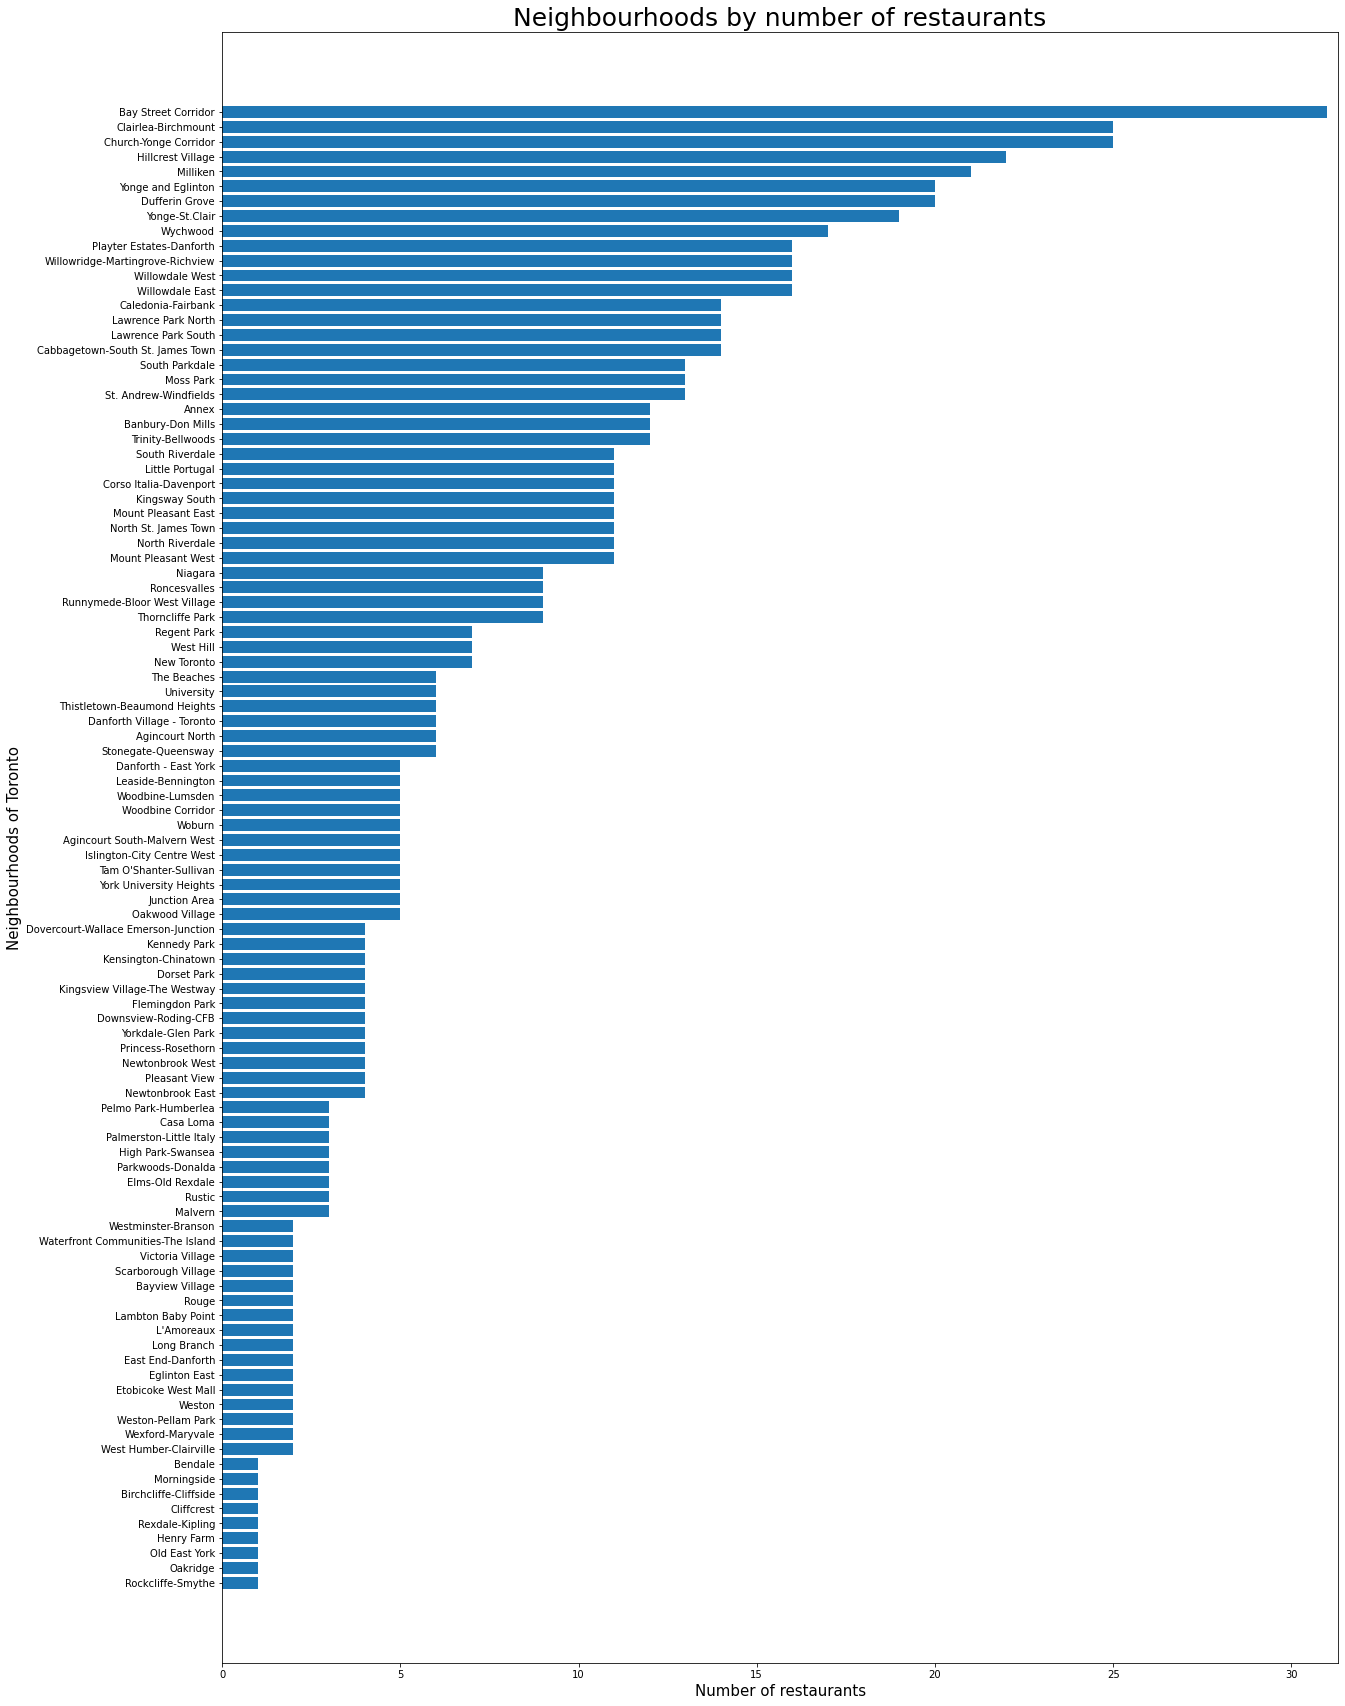

In [258]:
plt.figure(figsize = (20, 30))
plt.margins(0.01, 0.05)
plt.barh(restaurant_sort['Neighbourhood'], restaurant_sort['Total'])
plt.ylabel('Neighbourhoods of Toronto', fontdict = {'fontsize': 15})
plt.xlabel('Number of restaurants', fontdict = {'fontsize': 15})
plt.title('Neighbourhoods by number of restaurants', fontdict = {'fontsize': 25})
plt.show()

In [259]:
restaurant_sort.sort_values(by = 'Total', ascending = False).head(10)

,Neighbourhood,Borough,Total
4,Bay Street Corridor,Old City of Toronto,31
12,Clairlea-Birchmount,Scarborough,25
11,Church-Yonge Corridor,Old City of Toronto,25
28,Hillcrest Village,North York,22
43,Milliken,Scarborough,21
96,Yonge and Eglinton,Old City of Toronto,20
20,Dufferin Grove,Old City of Toronto,20
97,Yonge-St.Clair,Old City of Toronto,19
95,Wychwood,Old City of Toronto,17
91,Willowridge-Martingrove-Richview,Etobicoke,16


Above we have a visual representation of the neighbourhoods with the greatest number of restaurants, and below that a table showing the top ten neighbourhoods in terms of number of restaurants. 

We can also look at the borough with the greatest number of neighbourhoods having restaurants:

In [260]:
restaurant_sort.groupby(['Borough']).count().sort_values(by = 'Total', ascending = False).head(5)

,Neighbourhood,Total
Borough,,
Old City of Toronto,38,38
Scarborough,20,20
North York,19,19
Etobicoke,13,13
East York,5,5


The above shows the neighbourhoods and the boroughs with the greatest number of restaurants. Opening a restaurant in the above locales would likely be successful.

## Finding the most popular type of restaurant

Of course, there are many different types of restaurants, serving many different kinds of cuisine. We refilter our data to see which cuisines are the most popular:

In [261]:
restype = (
    resturants
    .groupby(['Venue_Category'], as_index = False)
    .agg(Total = ('Venue', 'count'))
    .sort_values('Total', ascending = True)
)

restype.reset_index(drop = True).tail()

,Venue_Category,Total
47,Thai Restaurant,47
48,Sushi Restaurant,58
49,Fast Food Restaurant,68
50,Restaurant,70
51,Italian Restaurant,77


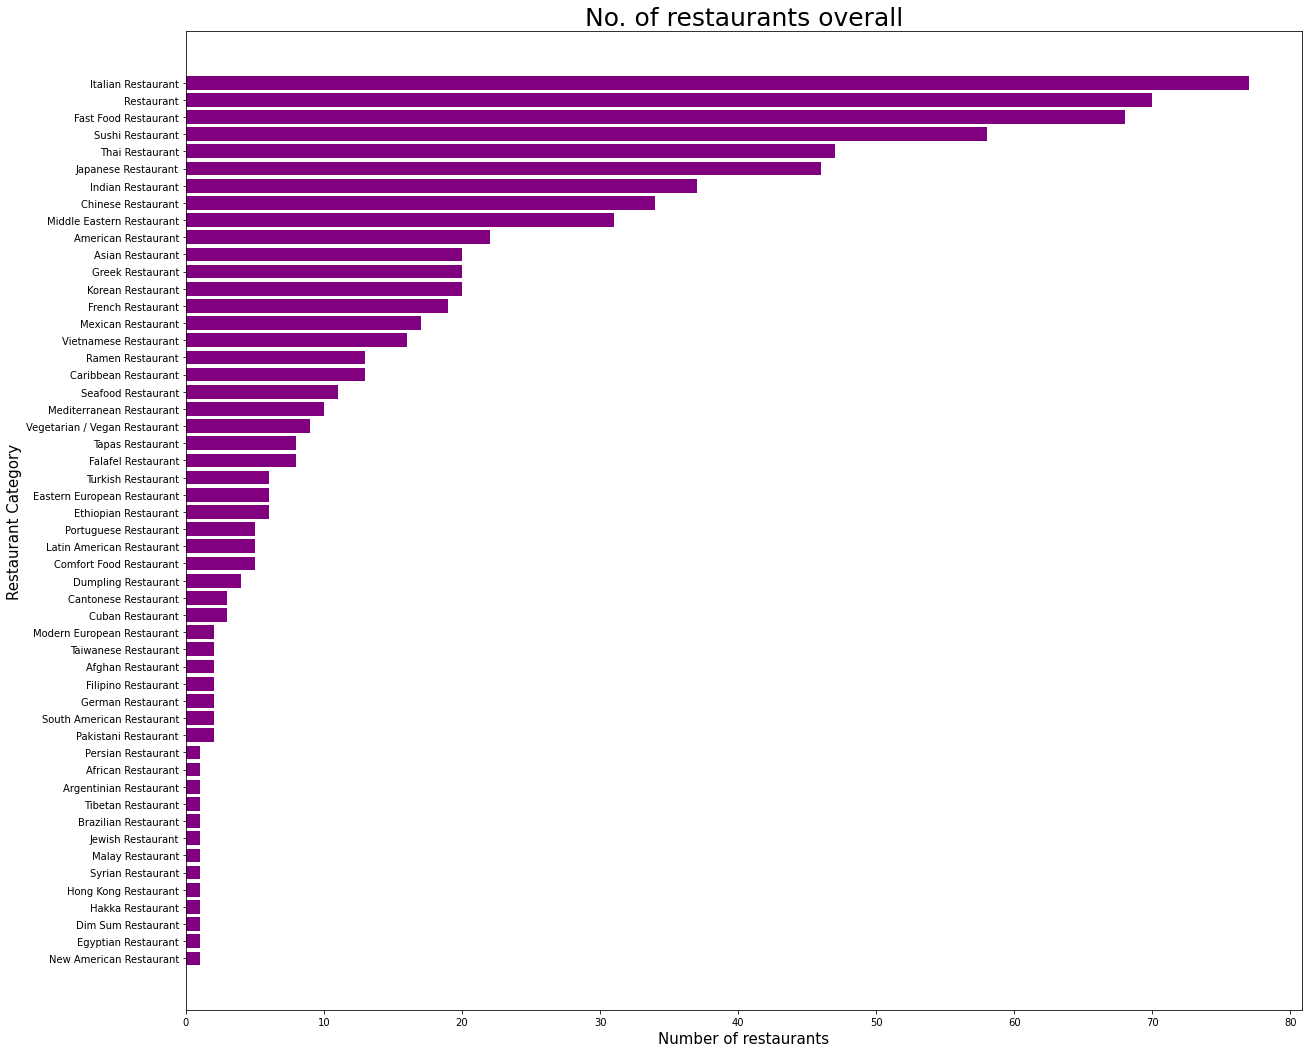

In [262]:
plt.figure(figsize = (20, 18))
plt.barh(restype['Venue_Category'], restype['Total'], color = 'purple')
plt.ylabel('Restaurant Category', fontdict = {'fontsize': 15})
plt.xlabel('Number of restaurants', fontdict = {'fontsize': 15})
plt.title('No. of restaurants overall', fontdict = {'fontsize': 25})
plt.show()

According to the bar chart above, Italian Restaurants are the most popular, followed by restaurants with no particular bent of cuisine. Unfortunately(or maybe fortunately), there aren't many Pakistani Restaurants. We shall see how many there are exactly: 

In [263]:
restype.loc[restype['Venue_Category'] == 'Pakistani Restaurant']

,Venue_Category,Total
36,Pakistani Restaurant,2


This shows that there are only two restaurants in Pakistan serving Pakistani cuisine, which may be better for us in the long run. We can check which neighbourhoods these restaurants are in:

In [264]:
pak_res = resturants.loc[resturants['Venue_Category'] == 'Pakistani Restaurant']
pak_res

,Cluster Label,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
817,3,Flemingdon Park,North York,43.718432,-79.333204,Shaheen Tikka & Kabab House,43.714011,-79.334296,Pakistani Restaurant
1319,3,Moss Park,Old City of Toronto,43.654644,-79.369728,King's Place647-352-0786,43.658278,-79.370925,Pakistani Restaurant


#### Checking the two neighbourhoods that have Pakistani restaurants to see what they are like overall:

In [265]:
resturants.loc[resturants['Neighbourhood'] == 'Flemingdon Park']

,Cluster Label,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
815,3,Flemingdon Park,North York,43.718432,-79.333204,Kaiseki Yu-Zen Hashimoto,43.720931,-79.337185,Japanese Restaurant
817,3,Flemingdon Park,North York,43.718432,-79.333204,Shaheen Tikka & Kabab House,43.714011,-79.334296,Pakistani Restaurant
822,3,Flemingdon Park,North York,43.718432,-79.333204,McDonald's,43.714692,-79.333817,Fast Food Restaurant
827,3,Flemingdon Park,North York,43.718432,-79.333204,Caribbean Palms Restaurant,43.714028,-79.334043,Caribbean Restaurant


In [266]:
resturants.loc[resturants['Neighbourhood'] == 'Moss Park']

,Cluster Label,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
1292,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Fusaro's,43.653347,-79.369517,Italian Restaurant
1294,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Schnitzel Queen,43.654239,-79.370533,German Restaurant
1295,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Mystic Muffin,43.652484,-79.372655,Middle Eastern Restaurant
1298,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Mangia and Bevi Resto-Bar,43.652250,-79.366355,Italian Restaurant
1299,3,Moss Park,Old City of Toronto,43.654644,-79.369728,GEORGE Restaurant,43.653346,-79.374445,Restaurant
1309,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Ardo,43.651201,-79.368350,Italian Restaurant
1317,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Souvlaki Express,43.655584,-79.364438,Greek Restaurant
1319,3,Moss Park,Old City of Toronto,43.654644,-79.369728,King's Place647-352-0786,43.658278,-79.370925,Pakistani Restaurant
1326,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Pita Land,43.651562,-79.367384,Falafel Restaurant
1327,3,Moss Park,Old City of Toronto,43.654644,-79.369728,Mengrai Gourmet Thai,43.654102,-79.366800,Thai Restaurant


## Now we find the popularity of the neighbourhoods in which Pakistani Restaurants are present:

In [267]:
restaurant_sort.loc[(restaurant_sort['Neighbourhood'] == 'Flemingdon Park') | (restaurant_sort['Neighbourhood'] == 'Moss Park')]

,Neighbourhood,Borough,Total
25,Flemingdon Park,North York,4
45,Moss Park,Old City of Toronto,13


From the bar chart above, we can see that Flemingdon Park is a less populous area, while Moss Park is more populated. However, to find the optimum place to open a restaurant, we need to see which neighbourhoods have a high to moderate Pakistani population, as they have a higher chance of enjoying the cuisine. For this, we check the ethnicities of the neighbourhoods, using the data from the 2016 census:

## Finding neighbourhoods with a high Pakistani ethnicity

First we check df_f shape:

In [268]:
df.shape

(2383, 146)

As seen, there are over 2000 rows, with each row representing a characteristic of the population. We only select those which are of interest to us:

In [269]:
df.loc[df['Characteristic'].str.contains('Pakistan')]

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1221,1222,Immigration and citizenship,Immigrants by selected place of birth,Census Profile 98-316-X2016001,Pakistan,"34,750",295,435,15,135,...,50,540,"1,550",95,35,10,15,30,505,20
1278,1279,Immigration and citizenship,Recent immigrants by selected place of birth,Census Profile 98-316-X2016001,Pakistan,"6,725",50,35,0,30,...,20,120,305,0,0,0,0,0,175,0
1591,1592,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Pakistani,"36,135",230,410,50,125,...,30,590,"1,605",80,55,10,40,55,515,35


We get three rows, two of which are in the Immigration and Citizenship, and one of which is in Ethnic Origin. We shall select the latter, as it could be a better indicator of cuisine taste.

In [270]:
pak_eth = df.iloc[1591].T.reset_index()

total_pak_eth = pak_eth.iloc[5,:]

pak_eth.drop([0,1, 2, 3, 4, 5], axis = 0, inplace = True)
pak_eth.columns = ['Neighbourhood', 'Pop. with Pakistani ethnicity']
pak_eth.reset_index(drop = True, inplace = True)

In [271]:
pak_eth.head()

,Neighbourhood,Pop. with Pakistani ethnicity
0,Agincourt North,230
1,Agincourt South-Malvern West,410
2,Alderwood,50
3,Annex,125
4,Banbury-Don Mills,325


In [272]:
pak_eth.shape

(140, 2)

We see above our table above shows the number of people of Pakistani ethnici origin in each neighbourhood of Toronto. We can also see the total number of people of Pakistani origin in Toronto with the following:

In [273]:
print('Total number of people of Pakistani origin in Toronto: {}'.format(total_pak_eth.iloc[1]))

Total number of people of Pakistani origin in Toronto: 36,135


There is still a problem with the table above: all the numberical values are actually strings, as seen below:

In [274]:
pak_eth['Pop. with Pakistani ethnicity'].dtypes

dtype('O')

We need to convert them all to int to construct our chart. For this we clean the data the following way:

In [275]:
for i in range(len(pak_eth['Pop. with Pakistani ethnicity'])):
    pak_eth['Pop. with Pakistani ethnicity'][i] = pak_eth['Pop. with Pakistani ethnicity'][i].replace(',', '')

pak_eth['Pop. with Pakistani ethnicity'] = pak_eth['Pop. with Pakistani ethnicity'].astype(int)

Now we can see their type:

In [276]:
pak_eth['Pop. with Pakistani ethnicity'].dtypes

dtype('int32')

### Now we build our bar chart:

#### Bar chart showing all neighbourhoods by the number of Pakistani origin people:

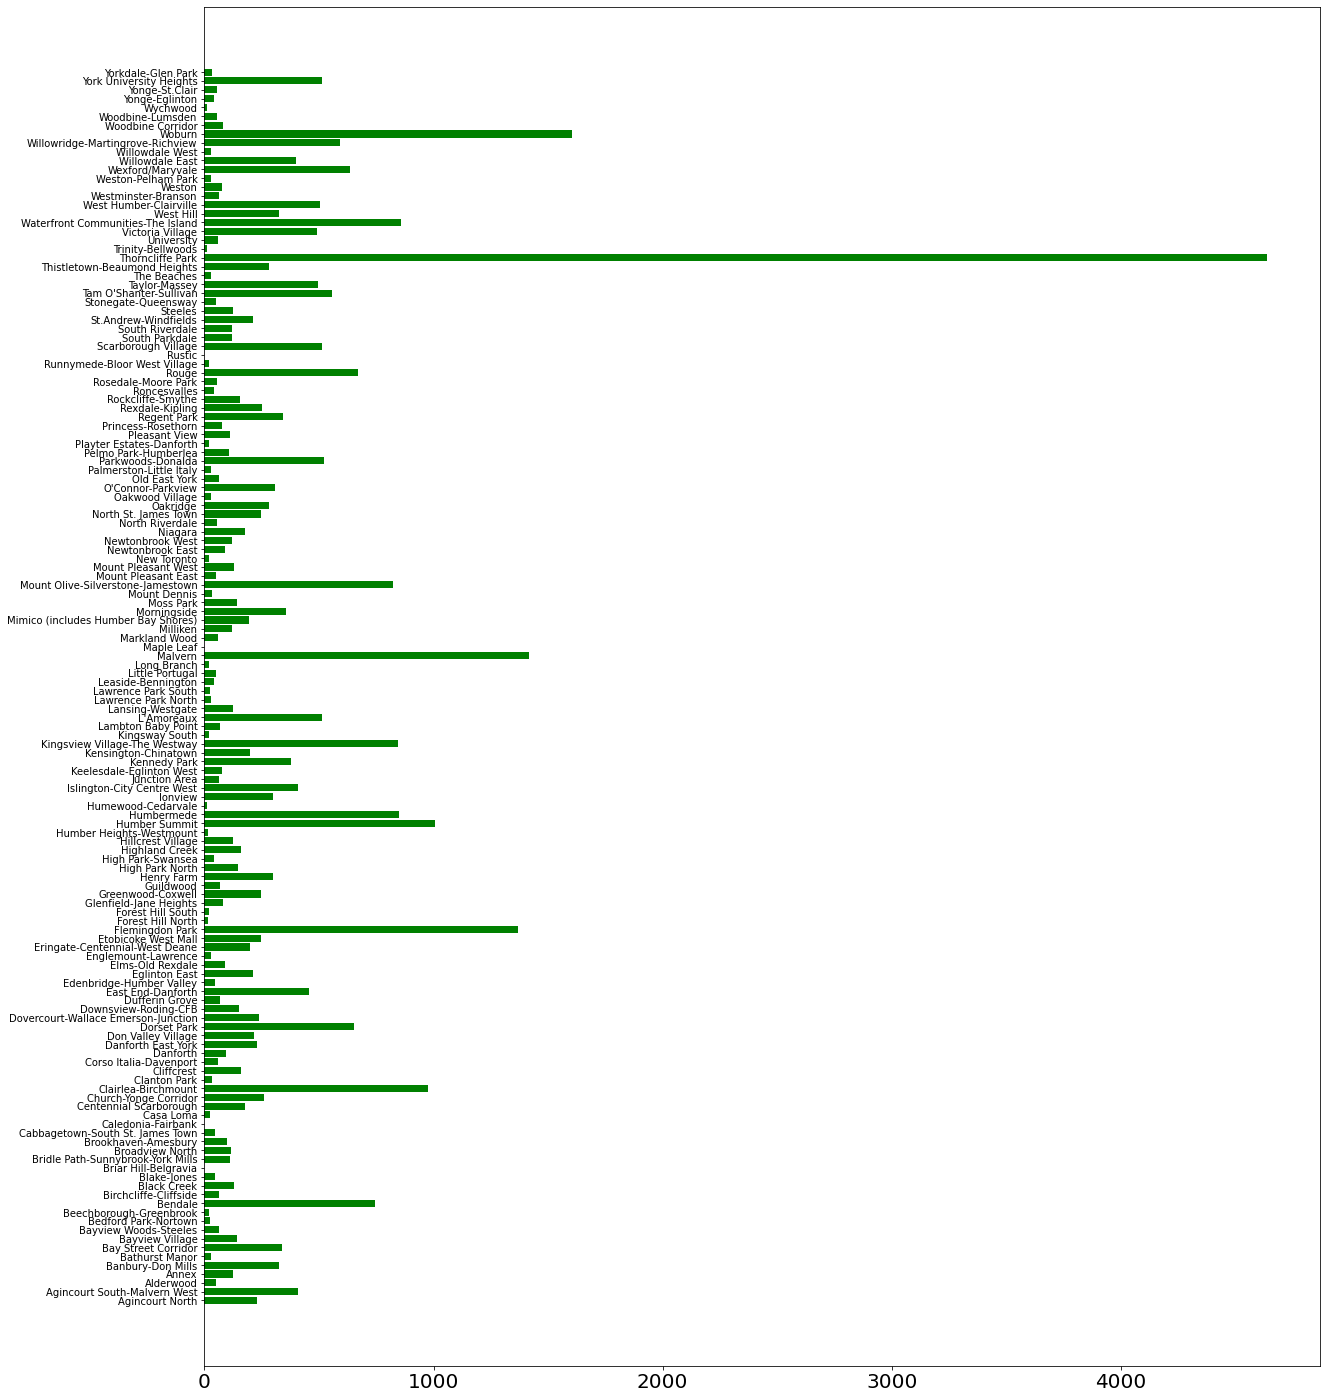

In [277]:
plt.figure(figsize =(20, 25))
plt.barh(pak_eth['Neighbourhood'], pak_eth['Pop. with Pakistani ethnicity'], color = 'green')
plt.xticks(fontsize=20)
plt.show()

Most neighbourhoods have few people of Pakistani origin; however, Thorncliffe Park stands out with the greatest number. It would be interesting to see the distance between Thorncliffe Park and the two neighbourhoods that have Pakistani restaurants. 

In fact, a location which minimizes the distance between the top 5 locales with the greatest number of Pakistani ethnicity people would be even more helpful.

In [278]:
thorncliffe = pak_eth.loc[pak_eth['Neighbourhood'] == 'Thorncliffe Park']
thorncliffe

,Neighbourhood,Pop. with Pakistani ethnicity
118,Thorncliffe Park,4640


In [279]:
thorn_coords = tor_ngh_data.loc[tor_ngh_data['Location'] == 'Thorncliffe Park']
thorn_coords

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
118,East York,Thorncliffe Park,43.704553,-79.345407,NaN


In [280]:
thorn_lat = thorn_coords.iloc[0,2]
thorn_lng = thorn_coords.iloc[0,3]
thorn_ngh = thorn_coords.iloc[0,1]
thorn_bor = thorn_coords.iloc[0,0]
thorn_pop = thorncliffe.iloc[0,1]

In [281]:
pak_res_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

label = '{}, {}, {}'.format(thorn_ngh, thorn_bor, thorn_pop)
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [thorn_lat, thorn_lng],
    radius=10,
    popup=label,
    parse_html=False).add_to(pak_res_map)  

for lat, lng, neighbourhood, category, venue in zip(
    pak_res['Neighbourhood_Latitude'], pak_res['Neighbourhood_Longitude'], pak_res['Neighbourhood'], pak_res['Venue'], pak_res['Borough']):
    label = '{}, {}, {}'.format(venue, neighbourhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=1,
        parse_html=False).add_to(pak_res_map)  
    
pak_res_map

We can see that the two Pakistani restaurants are scattered around the neighbourhood with the greatest number of Pakistani people, which seems like a prudent business decision. If we follow the same idea, it would be likely that our restaurant finds success.

So what we have to do next is to find the top 5 places with Pakistani people. Then, we calculate the Euclidean distances between them to calculate the ideal spot. Trying to get it closer to Flemingdon Park would also be nice, since it is likly for there to be a food street or similar over there.

In [282]:
top_5 = pak_eth.sort_values(by = 'Pop. with Pakistani ethnicity', ascending = False).head().reset_index(drop = True)
tdf = pd.DataFrame(columns = tor_ngh_data.columns)

for hood in top_5['Neighbourhood']:
    tdf = tdf.append(tor_ngh_data.loc[tor_ngh_data['Location'] == hood])
    
top_5_nghs = top_5.merge(tdf, left_on = 'Neighbourhood', right_on = 'Location')

In [283]:
top_5_nghs

,Neighbourhood,Pop. with Pakistani ethnicity,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Thorncliffe Park,4640,East York,Thorncliffe Park,43.704553,-79.345407,NaN
1,Woburn,1605,Scarborough,Woburn,43.759824,-79.225291,NaN
2,Malvern,1415,Scarborough,Malvern,43.809196,-79.221701,Malvern
3,Flemingdon Park,1370,North York,Flemingdon Park,43.718432,-79.333204,Flemingdon Park
4,Humber Summit,1005,North York,Humber Summit,43.760078,-79.571760,Humber Summit


In [284]:
top_5_nghs['Neighbourhoods covered'].fillna(top_5_nghs['Location'], inplace = True)
top_5_nghs.drop('Location', axis = 1, inplace = True)

In [285]:
cols = list(top_5_nghs.columns)
top_5 = top_5_nghs[[cols[0]] + cols[2:7] + [cols[1]]]
top_5

,Neighbourhood,Borough,Latitude,Longitude,Neighbourhoods covered,Pop. with Pakistani ethnicity
0,Thorncliffe Park,East York,43.704553,-79.345407,Thorncliffe Park,4640
1,Woburn,Scarborough,43.759824,-79.225291,Woburn,1605
2,Malvern,Scarborough,43.809196,-79.221701,Malvern,1415
3,Flemingdon Park,North York,43.718432,-79.333204,Flemingdon Park,1370
4,Humber Summit,North York,43.760078,-79.571760,Humber Summit,1005


In [286]:
x = np.mean(top_5['Latitude'])
y = np.mean(top_5['Longitude'])

resul = [x, y]

In [287]:
opt_loc_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 10)

label = '{}, {}, {}'.format(thorn_ngh, thorn_bor, thorn_pop)
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [thorn_lat, thorn_lng],
    radius=10,
    popup=label,
    parse_html=False).add_to(pak_res_map)  

label = 'Optimum Spot'
label = folium.Popup(label, parse_html=True)
folium.Marker(
    [resul[0], resul[1]],
    radius=10,
    popup=label,
    parse_html=False).add_to(opt_loc_map)  

for lat, lng, neighbourhood, borough, pop in zip(
    top_5['Latitude'], top_5['Longitude'], top_5['Neighbourhood'], top_5['Borough'], top_5['Pop. with Pakistani ethnicity']):
    label = 'Neighbourhood: {}, \nBorough: {}, \nPop. with Pakistani ethnicity: {}'.format(neighbourhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color= ngh_colours[neighbourhood],
        fill=True,
        fill_color= ngh_colours[neighbourhood],
        fill_opacity=1,
        parse_html=False).add_to(opt_loc_map)  
    
opt_loc_map

# Moving onto K-MEans clustering!!!!

So we can see that the five neighbourhoods are rather spread out, and are skewing our results quite a bit. It would be 
more prudent to cluster them and see what we come up with:

better to remove them so that we can obtain a much more precise location that maximizes our chances of getting more customers. We look at the top 5 locations of Pakistani origin people again:

In [288]:
latlng = []

for lat, lng in zip(top_5['Latitude'], top_5['Longitude']):
    row = [lat, lng]
    latlng.append(row)
    
latlng

[[43.704553, -79.3454074],
 [43.7598243, -79.2252908],
 [43.8091955, -79.2217008],
 [43.7184315, -79.333204],
 [43.7600778, -79.5717598]]

Since it is obvious from visually looking at our data that it divides into three clusters, we shall use k = 3:

In [289]:
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(latlng)
kmeans.labels_

array([1, 2, 2, 1, 0])

In [290]:
top_5_copy = top_5.copy()
top_5_copy.insert(0, 'Cluster Labels', kmeans.labels_)

In [291]:
top_5_copy

,Cluster Labels,Neighbourhood,Borough,Latitude,Longitude,Neighbourhoods covered,Pop. with Pakistani ethnicity
0,1,Thorncliffe Park,East York,43.704553,-79.345407,Thorncliffe Park,4640
1,2,Woburn,Scarborough,43.759824,-79.225291,Woburn,1605
2,2,Malvern,Scarborough,43.809196,-79.221701,Malvern,1415
3,1,Flemingdon Park,North York,43.718432,-79.333204,Flemingdon Park,1370
4,0,Humber Summit,North York,43.760078,-79.571760,Humber Summit,1005


We need to find the equidistant point in each cluster

In [292]:
optpoints = []

for point in top_5_copy['Cluster Labels'].unique():
    subset = top_5_copy.loc[top_5_copy['Cluster Labels'] == point]
    meanx = np.mean(subset['Latitude'])
    meany = np.mean(subset['Longitude'])
    
    optpoint = {'Cluster Labels': point, 'Optimum Point Latitude': meanx, 'Optimum Point Longitude': meany}
    
    optpoints.append(optpoint)
    
optpoints = pd.DataFrame(optpoints)

In [293]:
optpoints

,Cluster Labels,Optimum Point Latitude,Optimum Point Longitude
0,1,43.711492,-79.339306
1,2,43.784510,-79.223496
2,0,43.760078,-79.571760


In [294]:
optpointdict = {}

for clabel, pointlat, pointlng in zip(optpoints['Cluster Labels'], optpoints['Optimum Point Latitude'], optpoints['Optimum Point Longitude']):
    geolocator = Nominatim(user_agent='Final_Project_TBotN')
    coordinates = pointlat, pointlng
    location = geolocator.reverse(coordinates)
    clusloc = location.raw['address']
    optpointdict.update({clabel: clusloc})


We take a look at each of the addresses we got:

In [295]:
for label, address in optpointdict.items():
    print(label, address)

1 {'road': 'Don Trail', 'neighbourhood': 'Flemingdon Park', 'quarter': 'Don Valley East', 'city_district': 'North York', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'M3C 1B2', 'country': 'Canada', 'country_code': 'ca'}
2 {'house_number': '101', 'road': 'Pegasus Trail', 'quarter': 'Scarborough—Guildwood', 'suburb': 'Scarborough', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'M1G 3N2', 'country': 'Canada', 'country_code': 'ca'}
0 {'house_number': '3057', 'road': 'Islington Avenue', 'neighbourhood': 'Humber Summit', 'quarter': 'Humber River—Black Creek', 'city_district': 'North York', 'city': 'Toronto', 'state_district': 'Golden Horseshoe', 'state': 'Ontario', 'postcode': 'L4L 4T5', 'country': 'Canada', 'country_code': 'ca'}


We see that each point a similar, but not quite identical structure;  'neighbourhood' and 'quarter' appear to have been used interchangeably, as have 'suburb' and 'city_district'. We will have to exrtact them through another loop to get the correct neighbourhood and borough.

In [296]:
optpointaddresses = []

for label, address in optpointdict.items():
    if 'neighbourhood' in address:
        row = {'Cluster Labels': label, 'Neighbourhood': address['neighbourhood'], 'Borough': address['city_district']}
    else:
        row = {'Cluster Labels': label, 'Neighbourhood': address['quarter'], 'Borough': address['suburb']}
        
    optpointaddresses.append(row)
    
temp = pd.DataFrame(optpointaddresses)
    

In [297]:
optpoints = optpoints.merge(temp, on = 'Cluster Labels')

In [298]:
optpoints

,Cluster Labels,Optimum Point Latitude,Optimum Point Longitude,Neighbourhood,Borough
0,1,43.711492,-79.339306,Flemingdon Park,North York
1,2,43.784510,-79.223496,Scarborough—Guildwood,Scarborough
2,0,43.760078,-79.571760,Humber Summit,North York


Now we map the optimum point of each cluster on the map, along with the neighbourhoods in that cluster:

In [306]:
all_opt_loc_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 11)

cluster_colour = {}

for clabel, pointlat, pointlng, ngh, bor in zip(optpoints['Cluster Labels'], optpoints['Optimum Point Latitude'], optpoints['Optimum Point Longitude'], optpoints['Neighbourhood'], optpoints['Borough']):
    label = 'Optimum point no. {};\nNeighbourhood: {}\nBorough: {}'.format((clabel + 1), ngh, bor)
    colour = get_color_list()
    cluster_colour.update({clabel: colour})
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [pointlat, pointlng],
        popup=label,
        parse_html=False).add_to(all_opt_loc_map)  
    folium.Circle(
        [pointlat, pointlng],
        radius = 1000,
        parse_html=False).add_to(all_opt_loc_map)  



for lat, lng, neighbourhood, borough, pop, clabel in zip(
    top_5_copy['Latitude'], top_5_copy['Longitude'], top_5_copy['Neighbourhood'], top_5_copy['Borough'], top_5_copy['Pop. with Pakistani ethnicity'], top_5_copy['Cluster Labels']):
    label = 'Neighbourhood: {}, \nBorough: {}, \nPop. with Pakistani ethnicity: {}'.format(neighbourhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= cluster_colour[clabel],
        fill=True,
        fill_color= cluster_colour[clabel],
        fill_opacity=1,
        parse_html=False).add_to(all_opt_loc_map)  
    
for clabel, lat, lng, size, color in zip(clusters['Cluster Label'], clusters['Latitude'], clusters['Longitude'], clusters['Size'], clusters['Colour']):
    label = 'Restaurant cluster: {}\nNo. of restaurants: {}'.format(clabel, size)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
            [lat, lng],
            radius= size * 10,
            popup=label,
            color= color,
            fill=True,
            fill_color= color,
            fill_opacity=0.3,
            parse_html=False).add_to(all_opt_loc_map)  
    
all_opt_loc_map

Now we see the optimum points for each cluster of neighbourhoods. 

The opaque circles represent the five neighbourhoods that have the highest population of people having Pakistani origins. They match colours with other neighbourhoods close to them (ie., in their cluster).

The pin markers represent the optimum points to open a restaurant for each cluster of neighbourhoods.

The translucent circles represent clusters of restaurants, with the size of the circles representing the number of restaurants close by. 

Point 1 would be close to the people living in the neighbourhood, and also that it is in a region with few restaurants, meaning that people would be more likely to go to it. 

The pros 

(OPTIONAL): Work on finding info on the cluster opt points [geocoder]<b>{DONE}</b>. Also, see if its possible to cluster ALL restaurants, and find the closest cluster to each point[kmeans with lat and lng].